# **Movies reccomandation system.** 
<br>
In this notebook I will create a simple reccomendation system using the movie dataset. In particular, I will use a specific type of collaborative-filtering reccomandation system, called "frequently bought together". Such models usually require a triplet (user, product, rating), but for this specific implementation with apriori we will only use couples (user, product). Therefore, we need to transform our data in the proper format: for each user, which movies did he watch? Then, we will build our model and we will try to understand one prediction.

In [4]:
#importing libraries and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [5]:
#importing data
ratings_filename = Path('TheMovieDataSet/ratings_small.csv').resolve()
movies_filename = Path('TheMovieDataSet/movies_metadata.csv').resolve()
df_ratings = pd.read_csv(ratings_filename) # userId, movieId of the movie watched, rating and timestamp
df_movies = pd.read_csv(movies_filename) # info about the movie

C:\Users\andre\AppData\Local\Temp\ipykernel_9256\1397104193.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_movies = pd.read_csv(movies_filename) # info about the movie


### Let's explore our dataframes

In [6]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [7]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [8]:
df_ratings.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


In [9]:
df_movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [10]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [11]:
df_movies.describe()

,revenue,runtime,vote_average,vote_count
count,4.546000e+04,45203.000000,45460.000000,45460.000000
mean,1.120935e+07,94.128199,5.618207,109.897338
std,6.433225e+07,38.407810,1.924216,491.310374
min,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,85.000000,5.000000,3.000000
50%,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,107.000000,6.800000,34.000000
max,2.787965e+09,1256.000000,10.000000,14075.000000


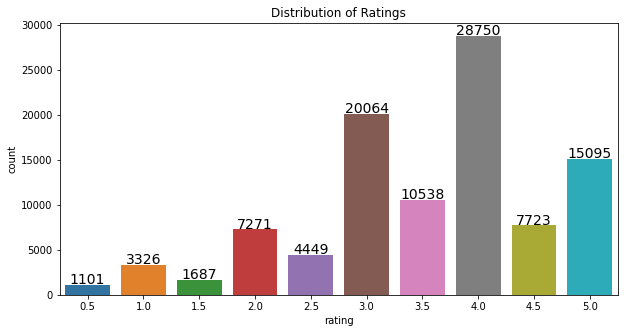

In [12]:
#let's analyze the ratings with a simple graph
plt.figure(figsize=(10,5))
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')

labels = df_ratings['rating'].value_counts().sort_index() #all the possible unique ratings with their counts
ax = sns.countplot(data=df_ratings, x='rating') #set the ratings as x values

for i,v in enumerate(labels):
    ax.text(i, v+100, str(v), horizontalalignment='center', size=14, color='black')
plt.show()

_The ratings distribution shows that there are relatively fewer movies that are lower rated. This can be because most of the users who didn't like the movie, didn't care enough to rate the movie. We wouldn't want to recommend movies with relatively low number of ratings as users probably didn't like them._

### Let's clean, merge and format our datasets

In [13]:
df_movies[df_movies['title'].isna() == True]
#6 rows with NaN title, let's clean
title_mask = df_movies['title'].isna()
df_movies = df_movies.loc[title_mask == False]
df_movies[df_movies['title'].isna() == True]
#everything seems fine now

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count


In [14]:
#looking at the data types, we can notice that the movies ID in the movies dataset are strings, whereas the movies ID in the rating datasets are integer.
df_movies = df_movies.astype({'id': 'int64'}) 
#now we can join the datasets on the column movie ID: left ratings, right movies (we just bring the title in the other table)
df = pd.merge(df_ratings, df_movies[['id', 'title']], left_on='movieId', right_on='id')


In [15]:
df.head()

,userId,movieId,rating,timestamp,id,title
0,1,1371,2.5,1260759135,1371,Rocky III
1,4,1371,4.0,949810302,1371,Rocky III
2,7,1371,3.0,851869160,1371,Rocky III
3,19,1371,4.0,855193404,1371,Rocky III
4,21,1371,3.0,853852263,1371,Rocky III


In [16]:
df.describe()

,userId,movieId,rating,timestamp,id
count,44994.000000,44994.000000,44994.000000,4.499400e+04,44994.000000
mean,345.963395,6010.754901,3.560986,1.089527e+09,6010.754901
std,194.871031,15918.243916,1.053169,1.878648e+08,15918.243916
min,1.000000,2.000000,0.500000,7.896520e+08,2.000000
25%,177.000000,500.000000,3.000000,9.472927e+08,500.000000
50%,359.000000,1394.000000,4.000000,1.053172e+09,1394.000000
75%,518.000000,2805.000000,4.000000,1.227918e+09,2805.000000
max,671.000000,160718.000000,5.000000,1.476623e+09,160718.000000


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44994 entries, 0 to 44993
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     44994 non-null  int64  
 1   movieId    44994 non-null  int64  
 2   rating     44994 non-null  float64
 3   timestamp  44994 non-null  int64  
 4   id         44994 non-null  int64  
 5   title      44994 non-null  object 
dtypes: float64(1), int64(4), object(1)
memory usage: 2.4+ MB


In [18]:
#column id is a replicate of moiveId and we neither need the timestamp
df.drop(['timestamp', 'id'], axis=1, inplace=True)
#let's make sure that there are no duplicate records for the combination of userId and title
df = df.drop_duplicates(['userId','title'])

In [19]:
#We need to format the data, in order to feed the apriori model in the appropriate way: what we want is a collection of user's watchlists: each column will be a movie and each row will be a different user, with info on the movie that they saw
#We can achieve this using the pivots
df_pivot = df.pivot(index='userId', columns='title', values='rating').fillna(0)
df_pivot.head()

title,!Women Art Revolution,'Gator Bait,'Twas the Night Before Christmas,...And God Created Woman,00 Schneider - Jagd auf Nihil Baxter,10 Items or Less,10 Things I Hate About You,"10,000 BC",11'09''01 - September 11,12 Angry Men,...,Zodiac,Zombie Flesh Eaters,Zombie Holocaust,Zozo,eXistenZ,xXx,¡Three Amigos!,À nos amours,Ödipussi,Şaban Oğlu Şaban
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
#We do not care about the ratings, we just want to know if a user saw a movie (1) or not (0)
#first, we must convert all floats to integers
df_pivot = df_pivot.astype('int64')

def encode_ratings(x):
    if x<=0:
        return 0
    if x>=1:
        return 1

df_pivot = df_pivot.applymap(encode_ratings)
df_pivot.head()

title,!Women Art Revolution,'Gator Bait,'Twas the Night Before Christmas,...And God Created Woman,00 Schneider - Jagd auf Nihil Baxter,10 Items or Less,10 Things I Hate About You,"10,000 BC",11'09''01 - September 11,12 Angry Men,...,Zodiac,Zombie Flesh Eaters,Zombie Holocaust,Zozo,eXistenZ,xXx,¡Three Amigos!,À nos amours,Ödipussi,Şaban Oğlu Şaban
userId,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## And now it is Apriori Time

Apriori model calculates the probability to determine how likely a user will watch movie M2 if he has already watched a movie M1. It does so by computing support, confidence and lift for different combinations of movies.
<br>

### Support
Support of a movie M1 is the probability of users watching it out of all users.
$$ support(M) = \frac{\text{number of user watchlists containing M}}{\text{number of user watchlists}} $$
_Note: M1 can be a single movie or a group of movies_
<br>

### Confidence
Confidence of a movie is: out of the total users having watched movie M1, how many have also watched movie M2?
$$ \text{confidence(M1 -> M2)} = \frac{\text{number of user watchlists containing M1 and M2}}{\text{number of user watchlists containing M1}} $$
<br>

### Lift
Lift is the ratio of confidence and support.
$$ \text{lift(M1 -> M2)} = \frac{\text{confidence(M1 -> M2)}}{\text{support(M2)}} $$
From the definition of support, you know that Support(M2) is the likelihood of users watching movie M2 if you recommend it to all the users.
<br>
Confidence(M1 -> M2), is the likelihood of users watching movie M2 if you recommend it to only the users who have already watched movie M1. With confidence you recommend the movie to a subset of population.
<br>
Lift then by definition is the measure of increase in likelihood of users watching the movie M2 when we recommend it to the subset than when we recommend it to entire population. __So a high lift suggests there is some relation between the two movies and most of the users who have watched movie M1 are also likely to watch movie M2.__

In [21]:
from mlxtend.frequent_patterns import apriori
#frequent itemsets (satisfy a minimum suport)
frequent_itemset = apriori(df_pivot, min_support=0.07, use_colnames=True)
frequent_itemset.head()

c:\Users\andre\miniconda3\envs\mypython3.9\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.129657,"(20,000 Leagues Under the Sea)"
1,0.129657,(2001: A Space Odyssey)
2,0.298063,(48 Hrs.)
3,0.292101,(5 Card Stud)
4,0.093890,(A Brief History of Time)


In [22]:
from mlxtend.frequent_patterns import association_rules
#let's define the rules
rules = association_rules(frequent_itemset, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(20,000 Leagues Under the Sea)",(48 Hrs.),0.129657,0.298063,0.076006,0.586207,1.966724,0.037360,1.696349
1,(48 Hrs.),"(20,000 Leagues Under the Sea)",0.298063,0.129657,0.076006,0.255000,1.966724,0.037360,1.168245
2,"(20,000 Leagues Under the Sea)",(A Nightmare on Elm Street),0.129657,0.266766,0.081967,0.632184,2.369807,0.047379,1.993480
3,(A Nightmare on Elm Street),"(20,000 Leagues Under the Sea)",0.266766,0.129657,0.081967,0.307263,2.369807,0.047379,1.256382
4,(Back to the Future Part II),"(20,000 Leagues Under the Sea)",0.210134,0.129657,0.077496,0.368794,2.844379,0.050251,1.378858


In [23]:
#Results!
df_res = rules.sort_values(by=['lift'], ascending=False)
df_res.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
70959,(On Guard),"(The Garden of Eden, Muxmäuschenstill)",0.087928,0.099851,0.070045,0.796610,7.977991,0.061265,4.425733
70958,"(The Garden of Eden, Muxmäuschenstill)",(On Guard),0.099851,0.087928,0.070045,0.701493,7.977991,0.061265,3.055440
197233,"(Rope, Big Fish)","(Psycho, All the Way Boys)",0.092399,0.095380,0.070045,0.758065,7.947833,0.061232,3.739096
197236,"(Psycho, All the Way Boys)","(Rope, Big Fish)",0.095380,0.092399,0.070045,0.734375,7.947833,0.061232,3.416849
2541153,"(A Nightmare on Elm Street, 48 Hrs., Cockles a...","(Sissi, Rain Man, Back to the Future Part II, ...",0.093890,0.098361,0.071535,0.761905,7.746032,0.062300,3.786885


### Let's try to interpet the result for a movie

In [24]:
df_MIB = df_res[df_res['antecedents'].apply(lambda x: len(x) ==1 and next(iter(x)) == 'Men in Black II')]
df_MIB = df_MIB[df_MIB['lift'] > 2]
movies = df_MIB['consequents'].values

movie_list = []
for movie in movies:
    for title in movie:
        if title not in movie_list:
            movie_list.append(title)
print("A user saw Man in Black II, this is what we reccomend to him:")
print(movie_list[0:10])

A user saw Man in Black II, this is what we reccomend to him:
['Nostalgia', 'Terminator 3: Rise of the Machines', 'Jarhead', 'Sleepless in Seattle', 'Point Break', 'Young and Innocent', 'The Talented Mr. Ripley', 'The 39 Steps', 'Once Were Warriors', 'The Thomas Crown Affair']
